In [180]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [203]:
class SearchAreaEnvironment:
    
    def __init__(self, k_values_map, agents_start_positions):
        
        self.scaling = 1
        self.p = 1
        self.R = 15
        self.unit_vector_count = 8
        self.KVM = k_values_map #load all the k-values
        self.width = k_values_map.shape[1] #Width of the map
        self.height = k_values_map.shape[0] #height of the map
        self.dKVM = np.zeros((self.height, self.width)) #initialize discovered KVM.
        agents_start_positions = np.array(agents_start_positions)
        self.agents_start_pos = np.array(agents_start_positions, copy=True) #save starting positions
        self.agents_pos = np.array(agents_start_positions, copy=True) #vector of 1x2 containing information of the position of the agents
        self.agents_count = agents_start_positions.shape[0] #amount of agents
        self.path_matrices = np.array([[[0,0] for _ in range(self.unit_vector_count)] for _ in range(self.agents_count)]) #path matrices for each agent
        self.last_dKVM = None
        
        
        
    
    def plot_grid_with_agents_KVM(self):
        # Get the size of the grid
        grid_size = self.KVM.shape

        # Create a color map for k-values
        cmap = plt.cm.get_cmap("viridis")  # You can choose any other colormap

        # Plot the grid
        plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
        plt.imshow(self.KVM, cmap=cmap, vmin=np.min(self.KVM), vmax=np.max(self.KVM))

        # Add colorbar
        cbar = plt.colorbar()
        cbar.set_label("K-Value")

        # Plot agent positions
        for agent_pos in self.agents_pos:
            x, y = agent_pos
            plt.scatter(x, y, marker="X", s=100, color="red")
            plt.text(x, y, "Agent", ha="center", va="center", color="white")

        # Set axis labels and title
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Grid with K-Values and Agents")

        # Show the plot
        plt.show()
        
        
    
    
    
    def plot_grid_with_agents_dKVM(self):
        # Get the size of the grid
        grid_size = self.dKVM.shape

        # Create a color map for k-values
        cmap = plt.cm.get_cmap("viridis")  # You can choose any other colormap

        # Plot the grid
        plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
        plt.imshow(self.dKVM, cmap=cmap, vmin=np.min(self.dKVM), vmax=np.max(self.dKVM))

        # Add colorbar
        cbar = plt.colorbar()
        cbar.set_label("K-Value")

        # Plot agent positions
        for agent_pos in self.agents_pos:
            x, y = agent_pos
            plt.scatter(y, x, marker="X", s=100, color="red")
            #plt.text(x, y, "Agent", ha="center", va="center", color="white")

        # Set axis labels and title
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Grid with K-Values and Agents")

        # Show the plot
        plt.show()
    
    
    
    
        
        
    def reset(self):
        
        self.dKVM = np.zeros((self.height, self.width)) #the whole map is undiscovered
        self.agents_pos = np.array(self.agents_start_pos, copy=True) #set current positions to start positions
        
        
        
        
        
        
    def get_pos(self, label_agent):
        
        self.x, self.y = self.agents_pos[label_agent-1] #get current state of any drone
        
        return [self.x, self.y]
    
    
    
    
    
    
    def get_average_k_value(self, x, y):
        
        half_p = (self.p+1) // 2
        start_row = max(x - half_p, 0)
        end_row = min(x + half_p + 1, self.dKVM.shape[0]) 
        start_col = max(y - half_p, 0)
        end_col = min(y + half_p + 1, self.dKVM.shape[1])
            
        regional_k_value_sum = self.dKVM[start_row:end_row, start_col:end_col]
        
        regional_average_k_value = np.mean(regional_k_value_sum)
        
        return regional_average_k_value
    
    
    
    
    
        
    def get_dKVM(self): #update dKVM and last dKVM
        
        self.last_dKVM = np.array(self.dKVM, copy=True)
        
        for i in range(self.agents_count): 
            
            x,y = self.agents_pos[i]
            
            half_p = (self.p+1) // 2
            start_row = max(x - half_p, 0)
            end_row = min(x + half_p + 1, self.dKVM.shape[0]) 
            start_col = max(y - half_p, 0)
            end_col = min(y + half_p + 1, self.dKVM.shape[1])

            self.dKVM[start_row:end_row, start_col:end_col] = self.KVM[start_row:end_row, start_col:end_col]  #Update dKVM base on the location of every agents

            
            
            
            
    def new_path_matrices_update(self, path_matrcies):
        
        self.path_matrices = path_matrcies
        
        
        
        
           
            
            
            
        
    def difference_in_k(self):
        
        difference_k_array = []
        
        for i in range(self.agents_count):
            
            current_pos = self.get_pos(i+1)
            future_pos = current_pos + self.path_matrices[i][0]
            
            current_k = self.get_average_k_value(current_pos[0], current_pos[1])
            future_k = self.get_average_k_value(future_pos[0], future_pos[1])
            
            difference_in_k = future_k - current_k
            
            difference_k_array.append(difference_in_k)
            
        return np.array(difference_k_array)
            
    def encourage_k(self):
        
        difference_in_k = self.difference_in_k()
        
        reward = np.sum(difference_in_k)
        
        return reward
    
    def explored_area(self):
        
        explored_now = np.count_nonzero(self.dKVM)
        explored_before = np.count_nonzero(self.last_dKVM)
        total_count = self.width * self.height

        exploration_change = (explored_now - explored_before) / ((self.p*2 + 1)*self.agents_count)
        exploration_ratio = explored_before / total_count

        unexplored_ratio = 1 - exploration_ratio

        reward = exploration_change * unexplored_ratio

        return reward
            
        
    '''def calculate_proximity_penalty(self, agent_positions):
        max_range = self.R
        proximity_penalty = 0.0

        # Calculate the pairwise distances between all agents
        pairwise_distances = np.linalg.norm(agent_positions[:, np.newaxis] - agent_positions, axis=2)

        # Exclude self-distances by setting them to a large value
        np.fill_diagonal(pairwise_distances, np.inf)

        # Find the closest neighbor for each agent
        closest_neighbors = np.argmin(pairwise_distances, axis=1)

        # Calculate the distances between each agent and its closest neighbor
        closest_distances = pairwise_distances[np.arange(len(agent_positions)), closest_neighbors]

        # Apply penalty for agents outside the specified range
        outside_range_mask = closest_distances > max_range
        proximity_penalty += np.sum(closest_distances[outside_range_mask])

        return -proximity_penalty  # Return the penalty as a negative reward'''
    
    '''def calculate_concentration_penalty(self, agent_positions):
        concentration_penalty = 0.0
        
        # Calculate the mean k-value of the swarm based on get_k_value()
        mean_k_value = np.mean([self.get_average_k_value(x, y) for x, y in agent_positions])
        
        max_eps = (self.height + self.width) / (2*self.agents_count)
        eps = (1-mean_k_value) * max_eps

        # Perform clustering using DBSCAN
        dbscan = DBSCAN(eps, min_samples=1)
        labels = dbscan.fit_predict(agent_positions)

        # Get the unique cluster labels
        unique_labels = np.unique(labels)

        # Calculate the maximum allowed count based on adaptive sampling
        max_allowed_counts = np.zeros(len(agent_positions))
        for label in unique_labels:
            cluster_indices = np.where(labels == label)[0]
            cluster_count = len(cluster_indices)
            max_allowed_count = np.exp(-0.5 * (cluster_count - mean_k_value)**2)
            max_allowed_counts[cluster_indices] = max_allowed_count

        # Proportional allocation of agents based on max_allowed_counts
        max_allowed_counts *= len(agent_positions) / np.sum(max_allowed_counts)

        # Check if any clusters have too many drones and calculate concentration penalty
        for label in unique_labels:
            cluster_indices = np.where(labels == label)[0]
            cluster_count = len(cluster_indices)
            max_allowed_count = max_allowed_counts[cluster_indices]
            excess_count = cluster_count - max_allowed_count
            excess_count_mask = excess_count > 0  # Element-wise comparison
            if np.any(excess_count_mask):
                excess_count_sum = np.sum(excess_count[excess_count_mask])
                concentration_penalty += excess_count_sum

        return -concentration_penalty  # Return the penalty as a negative reward'''

        
        
        
        
        
    def take_action(self): #get path plan, move agents
        
        for i in range(self.agents_count): #update position of every agents
            
            pos_update = self.path_matrices[i][0] #next step move

            current_pos = self.get_pos(i+1) #current position
            new_pos = np.array([pos_update[0] + current_pos[0], pos_update[1] + current_pos[1]]) #sum
            
            self.agents_pos[i] = new_pos #update position
            
        self.process_old_path_matrices() #process the matrices to be ready to put into the neural network
            
            
            
            
            
    def process_old_path_matrices(self): #for old paths, remove the complete vector, add a new empty vector
        
        processed_path_matrices = []
        
        for agents in self.path_matrices:
            processed_path = list(agents[1:])  # Remove the first element of the second dimension
            processed_path.append([0, 0])  # Add [0, 0] at the end
            processed_path_matrices.append(processed_path)
            
        self.path_matrices = np.array(processed_path_matrices)

            
            
            
            
        
        

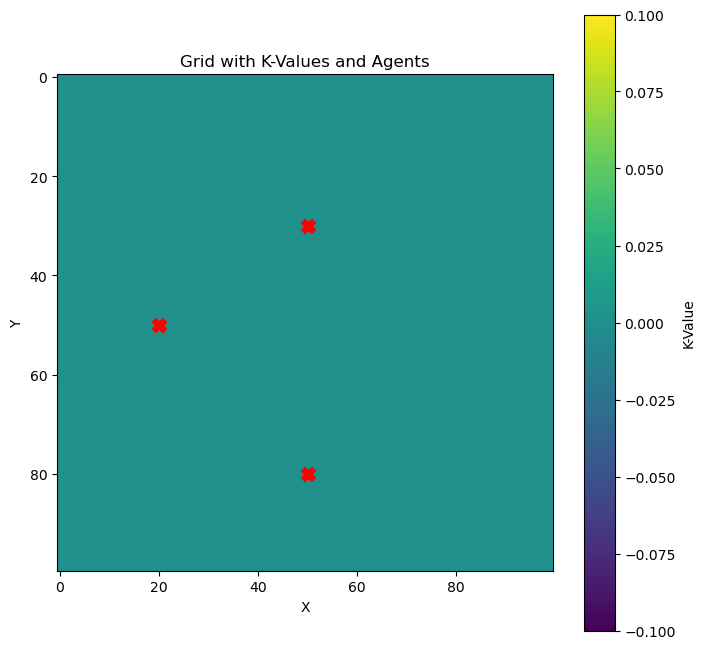

-0.43019553306438996
0.9973


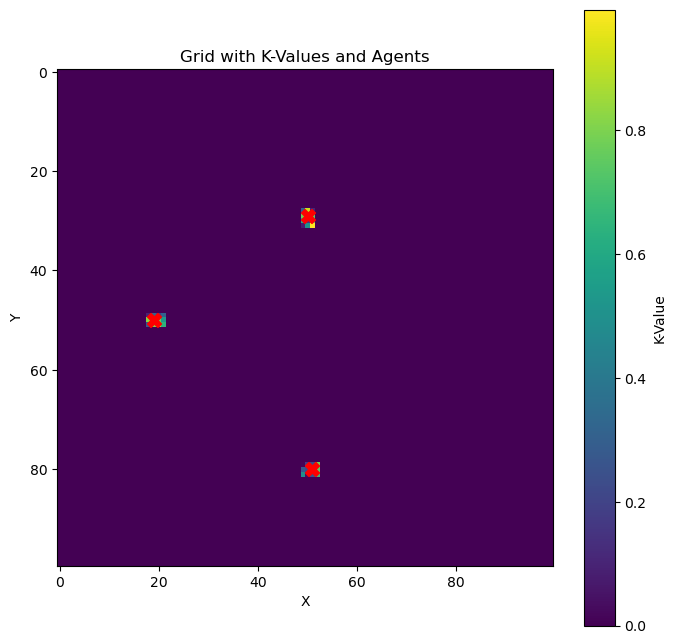

-0.2911761404093203
0.9964


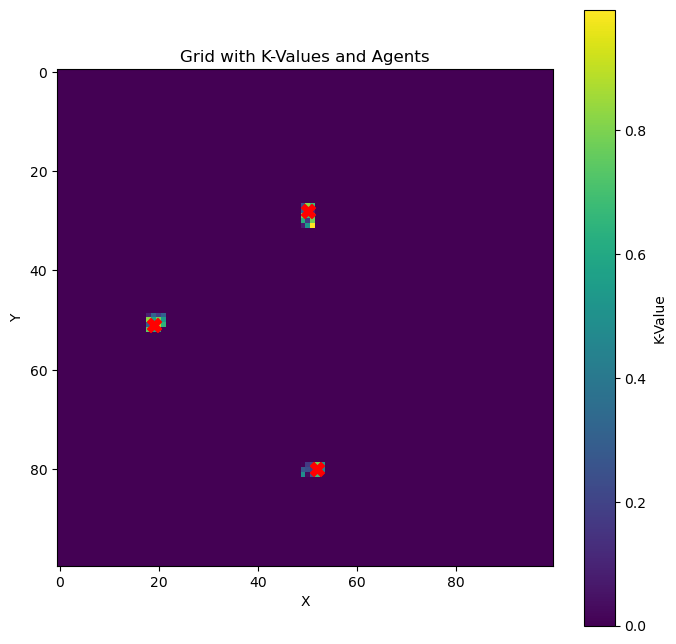

-0.5683476540619734
0.9955


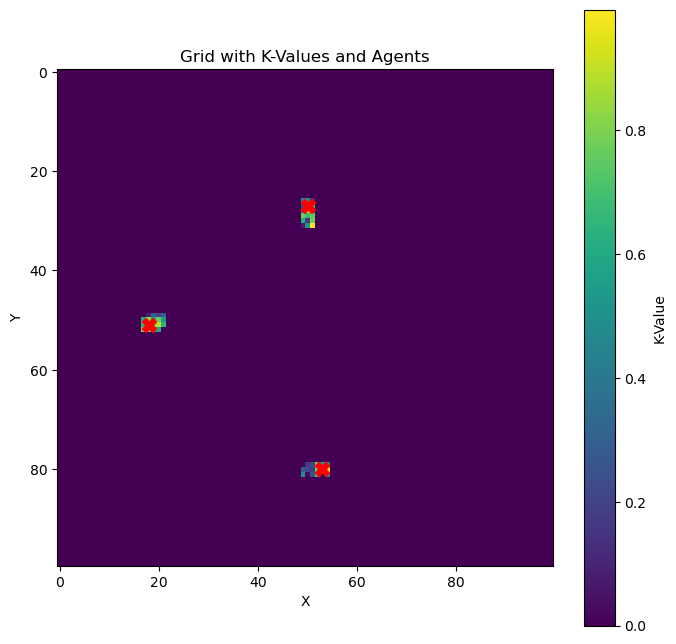

-0.6176801823501441
0.9946


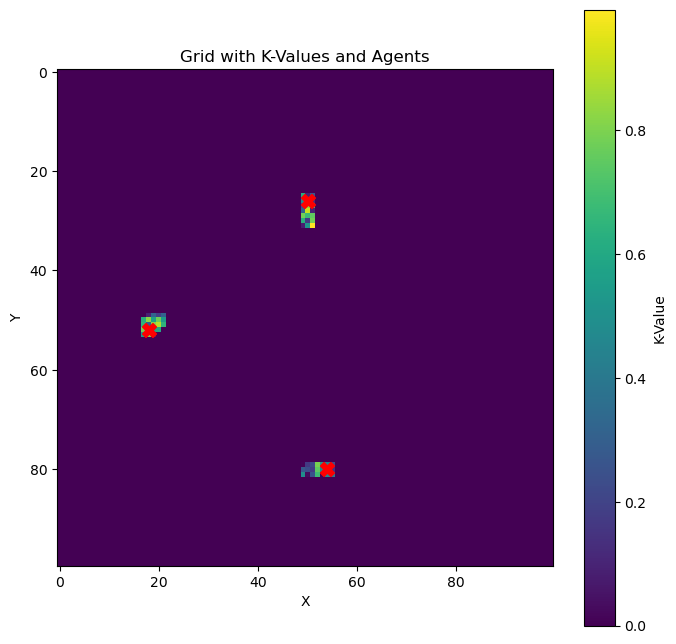

-0.4912743192112214
0.9937


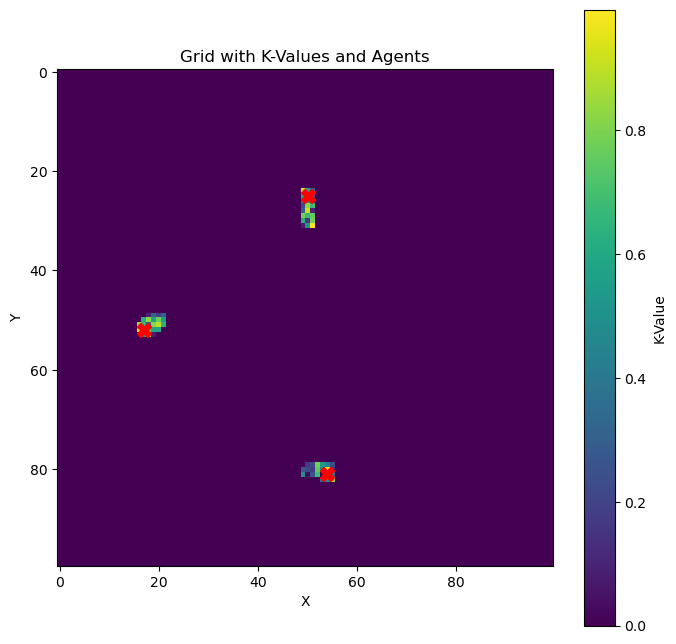

-1.478976757995909e-05
0.22062222222222222


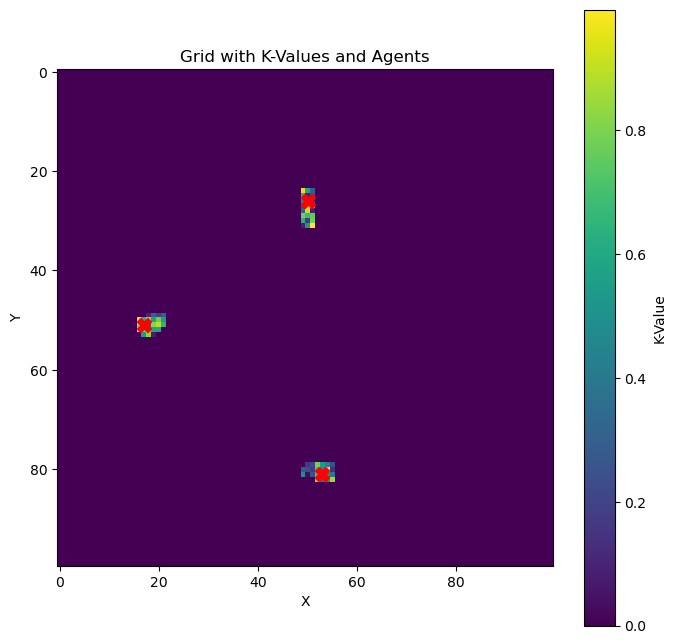

-0.3931436995536045
0.33086666666666664


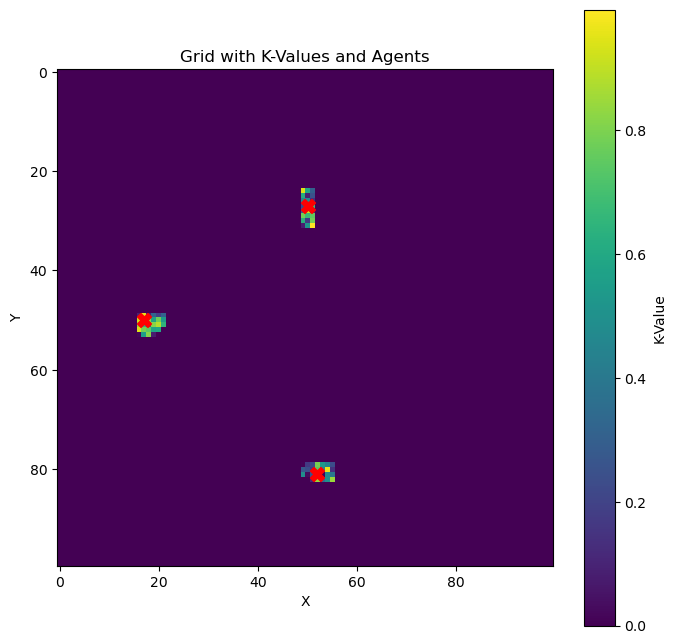

-0.13288659447796086
0.4410222222222222


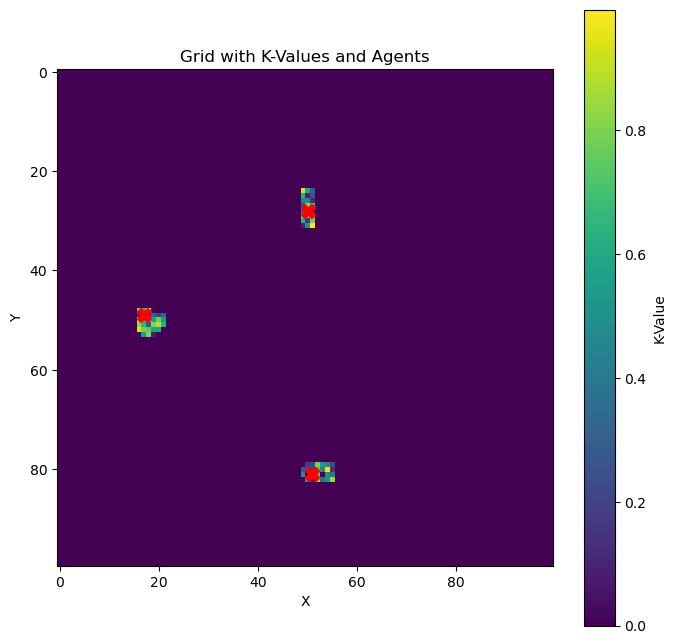

0.0
0.0


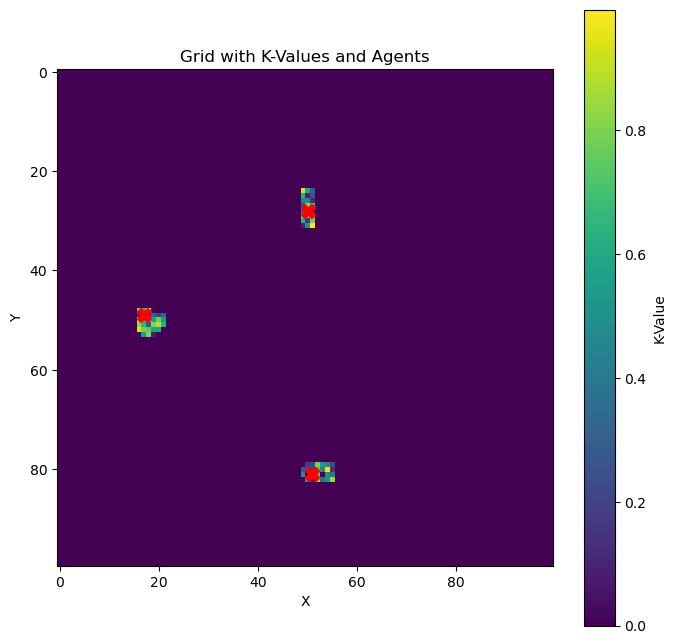

In [204]:
random_matrix = np.random.random((100,100))

env = SearchAreaEnvironment(random_matrix, np.array([[30, 50], [80, 50], [50, 20]]))

env.plot_grid_with_agents_dKVM()

env.get_dKVM()

move = np.array(
    [[[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [1, 0], [1, 0], [1, 0]], 
     [[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, -1], [0, -1], [0, -1]], 
     [[0, -1], [1, 0], [0, -1], [1, 0], [0, -1], [-1, 0], [-1, 0], [-1, 0]]]
)

env.new_path_matrices_update(move)

for i in range(9):
    
    print(env.encourage_k())

    env.take_action()

    env.get_dKVM()
    
    print(env.explored_area())

    env.plot_grid_with_agents_dKVM()


In [ ]:
'''get_dKVM -> agents_pos -> neural network (input, dKVM, self.path_matricies, agents_pos ) -> 
output(new_path_matricies) -> new_path_matrcies_update -> reward: encourage k -> take_action -> 
reward: exploration -> 
'''